# Run matlab model in cantera
Runs the thermodynamic (shomate) parameters and the kinetic (arrhenius) parameters from the matlab output files in "../Grabow_matlab_data". 


to check:  
- do all Eas and As agree? 
- do rates agree when we convert? 

- you accidentally set the reservoir and downstream to the SS mole fractions. you need the same inlet mole fractions as the experiment. that is probably why it is so low. 

In [73]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

import scipy.linalg as la
import scipy.io 

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.6.0a2


### important constants or values 

In [74]:
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3  # [kg/mol]
mw_h2 = 2.016e-3  # [kg/mol]
mw_h2o = 18.01528e-3  # [kg/mol]

kb = 1.3806503E-23
Na = 6.0221415E23
mamu = 1.66053886E-27
h = 6.626068E-34
R = 8.314

eV2kJ = 96.485

In [75]:
# need to load in surface to get site density 
file = "../../External_data/mech_grabow_new.cti"

gas = ct.Solution(file, "gas")
surf = ct.Interface(file,"surface1", [gas])

# kmol/m^2
site_density = surf.site_density
print("check site density is what we expect: ",2.9e-9*1e4/(1e3), site_density)

check site density is what we expect:  2.9e-08 2.8999999999999998e-08


### define functions to convert species and reactions

In [76]:
class matlab_species:
    def __init__(
         self,
         name,
         dHf0,
         S0,
         A,
         B,
         C,
         D,
         E,
         F,
         G,
         H,
         AtomicMass,
         EnergyOffset,
         BE_Fit,
         enthalpy,
         entropy,
         Pout,
         coverage,
    ): 
        """
        structure for storing species info from matlab file
        (shomates, etc)
        """
        self.dHf0 = dHf0
        self.S0 = S0
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.E = E
        self.F = F
        self.G = G
        self.H = H
        self.AtomicMass = AtomicMass
        self.EnergyOffset = EnergyOffset
        self.BE_Fit = BE_Fit
        self.enthalpy = enthalpy
        self.entropy = entropy
        self.Pout = Pout
        self.coverage = coverage

        # rename, remove g, replace "*"" with "X"
        if "g" in name:
            self.name = name.replace("g","")
        elif "*" in name:
            self.name = name.replace("*","X")
        else:
            self.name = name+"X"
            
        # hardcode rename of HCOOX to HCO2X because I am lazy
        if self.name == "HCO2X":
            self.name = "HCOOX"
        
        # calculate 7th parameter for cantera
        self.F_7param = self.dHf0 + self.F - self.H

        # add binding energy correction to F
        if abs(self.BE_Fit) > 0:
            self.F_7param = self.F_7param + self.BE_Fit*eV2kJ

        # add energy offset to F 
        if abs(self.EnergyOffset) > 0:
            self.F_7param = self.F_7param + self.EnergyOffset
        
        
        # create array of coefficients
        self.coeffs = [
            1000,
            self.A,
            self.B,
            self.C,
            self.D,
            self.E,
            self.F_7param,
            self.G,
            # for now, low and high are the same.
            self.A,
            self.B,
            self.C,
            self.D,
            self.E,
            self.F_7param,
            self.G,
        ]
            
        
        # create ct thermo object
        self.thermo = ct.ShomatePoly2(200, 2000, ct.one_atm, self.coeffs)

        

class matlab_rxn:
    
    def __init__(
         self,
         const_preexp,
         prettyprnt,
         rtype,
         species,
         stoichiometry,
         Ea,
         stickcoeff,
         omega,
         TSID,
         preexp,
         S_TS,
         Ha,
         ispecies,
         deltaH,
         dHDFT,
         EaDFT,
         deltaS,
         kfwd,
         Keq,
         krev,
         rfwd,
         rrev,
         rate,
    ): 
        """
        structure for storing reaction info from matlab file
        (deltaH, A-factor, etc.)
        """
        self.const_preexp = const_preexp
        self.prettyprnt = prettyprnt
        self.rtype = rtype
        self.species = species
        self.stoichiometry = stoichiometry
        self.Ea = Ea
        self.stickcoeff = stickcoeff
        self.omega = omega
        self.TSID = TSID
        self.preexp = preexp
        self.S_TS = S_TS
        self.Ha = Ha
        self.ispecies = ispecies
        self.deltaH = deltaH
        self.dHDFT = dHDFT
        self.EaDFT = EaDFT
        self.deltaS = deltaS
        self.kfwd = kfwd
        self.Keq = Keq
        self.krev = krev
        self.rfwd = rfwd
        self.rrev = rrev
        self.rate = rate
        
        
        # convert species list to new format
        new_spec = self.species
        for i , spec in enumerate(self.species):
            
            # rename, remove g, replace "*"" with "X"
            if "g" in spec:
                new_spec[i] = spec.replace("g","")
            elif "*" in spec:
                new_spec[i] = spec.replace("*","X")
            else:
                new_spec[i] = spec+"X"
                
            # hardcode rename of HCOOX to HCO2X because I am lazy
            if new_spec[i] == "HCO2X":
                new_spec[i]= "HCOOX"
        
        self.species = new_spec
        
        # put equation in same format as species
        self.new_equation = self.prettyprnt.replace(";","").replace("g", "")
        self.new_equation = self.new_equation.replace("*", "X").replace("->", "<=>")
        self.new_equation = self.new_equation.replace("HCO2X","HCOOX").replace(" ", "")
        
        # I am lazy and hardcoding these. cantera sometimes swaps 
        # reactants and products regardless of how they are in the input file
        if self.new_equation == "OHX+COX<=>COOHX+X":
            self.new_equation = "COX+OHX<=>COOHX+X"
            
        if self.new_equation == "H2OX+X<=>OHX+HX":
            self.new_equation = "H2OX+X<=>HX+OHX"
            
        if self.new_equation == "OHX+X<=>OX+HX":
            self.new_equation = "OHX+X<=>HX+OX"
            
        if self.new_equation == "OX+HCOX<=>OHX+COX":
            self.new_equation = "HCOX+OX<=>COX+OHX"
            
        if self.new_equation == 'OHX+HCOX<=>H2OX+COX':
            self.new_equation = 'HCOX+OHX<=>COX+H2OX'
            
        if self.new_equation == 'HCOOX+HCOX<=>HCOOHX+COX':
            self.new_equation = 'HCOOX+HCOX<=>COX+HCOOHX' 
            
        if self.new_equation == 'HCOOX+HCOX<=>H2CO2X+COX':
            self.new_equation = 'HCOOX+HCOX<=>COX+H2CO2X'
        
        if self.new_equation == "CH3OX+CH2OX<=>CH2OOCH3X+X":
            self.new_equation = 'CH2OX+CH3OX<=>CH2OOCH3X+X'
        
        # reaction rate is mol/site/sec
        # cantera A is m, Kmol, s units.
        if self.rtype == 0:
            # for now, don't convert
            A = self.stickcoeff
            self.A_orig = self.stickcoeff
        else:
            # for now, don't convert
            A = self.preexp 
            self.A_orig = self.preexp
        
        # no temperature exponents in model
        b = 0.0
        
        # save Ea with no correction: 
        self.Ea_orig = self.Ea*1e6
        print(self.new_equation, self.Ea_orig)


    def correct_rxns(self, species_dict, temp):
        """
        corrects reactions based on options chosen in matlab solver
        
        species_dict - dictionary of matlab_species objects, with the key as the species name
        temp - temp rxn is occurring at.
        """
        
        kB = 1.3806503E-23  # J/K
        h = 6.626068E-34;   # J
        R = 8.314           # J/mol/K
        
        
        deltaS_TS = self.S_TS
        
        if not self.const_preexp and self.rtype > 0:
            for spec, spec_obj in species_dict.items():
                if spec in self.species:
                    
                    index = self.species.index(spec)
                    
                    if self.stoichiometry[index] < 0: #reactants only
                        deltaS_TS = deltaS_TS + self.stoichiometry[index]*spec_obj.S0
#                         print(spec, self.species, index,self.stoichiometry[index] )
#                         print(deltaS_TS)

                        
            self.preexp = kB*temp/h*np.exp(deltaS_TS/R)
        
        # adjust Ea depending on omega
        self.Ea_corr = self.EaDFT + self.omega*(self.deltaH - self.dHDFT)
        if self.Ea_corr < self.deltaH:
            self.Ea_corr = self.deltaH
        
        self.Ea_corr = self.Ea_corr*1e6
        
        # save corrected Ea
            
        if self.rtype == 0:
            self.A_corr = self.stickcoeff#/0.573
        else:
            self.A_corr = self.preexp/site_density
            
        # no temperature exponents in model
        b = 0.0
        
        print(self.new_equation, self.Ea_corr)
        # make reaction object so we can update ct model
        self.arrhenius = ct.Arrhenius(self.A_corr, b, self.Ea_corr)       

# For A + X <=> AX

## $r_{mat} = k_{mat}P_{A}\Theta_{X}$

## $R = 8.314 J/mol/K$

unimolecular
## $k_{can} = k_{mat}\frac{RT*1e3}{1e5Pa}$

bi molecular (H2 adsorption dissoc)  
## $k_{can} = k_{mat}\frac{RT*1e3}{\Gamma*1e5Pa}$

# for Ax + BX <=> CX + DX

## $r_{can} = k_{can}C_{A}C_{X}^`$

## $k_{mat}= \frac{r_{mat}}{\Theta_{a}\Theta_{b}}$


## $k_{can} = \frac{r_{mat}\Gamma^{kmol}}{\Theta_{A}\Gamma^{kmol}\Theta_{B}\Gamma^{kmol}} = k_{mat}*\frac{1}{\Gamma}$


## $r_{can} = \frac{kmol}{m^{2}s}$

## $r_{mat} = \frac{mol}{site*s}$

## $A_{can} = A_{mat}*\frac{1}{\Gamma}$

## $\Gamma = \frac{kmol}{m^2}$

In [77]:
# get feed number and run number from file name
new_run = False

if new_run: 
    path_str = "../Grabow_matlab_data/MeOH_Feed_1_Run_1.mat"
    file_name = path_str.split("/")[-1]
    print(file_name.split("_")[2])
    feed = int(file_name.split("_")[2])
    run = int(file_name.split("_")[4].split(".")[0])
else: 
    path_str = "../Grabow_matlab_data/original_runs/Graaf1988_ExpID_1.mat"


# matlab workspace with all relevant values
mat = scipy.io.loadmat(path_str)

species = mat['species']
reactions = mat['reaction']

if new_run:
    conditions = mat['condition']
    
else: 
    # typo in original grabow data
    conditions = mat['ccondition']

In [78]:
# dictionary of matlab_species objects
species_dict = {}

for spec in species[0]:
    new_spec = matlab_species(
                name = str(spec[0][0]),
                dHf0 = float(spec[1][0]),
                S0= float(spec[2][0]),
                A = float(spec[3][0]),
                B = float(spec[4][0]),
                C = float(spec[5][0]),
                D = float(spec[6][0]),
                E = float(spec[7][0]),
                F = float(spec[8][0]),
                G = float(spec[9][0]),
                H = float(spec[10][0]),
                AtomicMass = float(spec[11][0]),
                EnergyOffset = 0 if spec[12][0].size==0 else float(spec[12][0]),
                BE_Fit= 0 if spec[13][0].size==0 else float(spec[13][0]),
                enthalpy = float(spec[14][0]),
                entropy = float(spec[15][0]),
                Pout = 0 if spec[16][0].size==0 else float(spec[16][0]),
                coverage = 0 if spec[17][0].size==0 else float(spec[17][0]),
    )
    species_dict[new_spec.name] = new_spec

In [79]:
float(conditions['T'])

483.5

In [80]:
# dictionary of matlab_rxn objects
rxn_dict = {}

for rxn in reactions[0]:
    new_rxn = matlab_rxn(
        const_preexp = float(rxn[0][0]),
        prettyprnt = str(rxn[1][0]),
        rtype = float(rxn[2][0]),
        species = [str(i[0]) for i in rxn[3][0]],
        stoichiometry = list(rxn[4][0]),
        Ea = float(rxn[5][0]),
        stickcoeff = 0 if rxn[6][0].size ==0 else float(rxn[6][0]),
        omega = float(rxn[7][0]),
        TSID = 0 if rxn[8][0].size ==0 else float(rxn[8][0]),
        preexp = 0 if rxn[9][0].size ==0 else float(rxn[9][0]),
        S_TS = 0 if rxn[10][0].size ==0 else float(rxn[10][0]),
        Ha = 0 if rxn[11][0].size ==0 else float(rxn[11][0]),
        ispecies = rxn[12][0],
        deltaH = float(rxn[13][0]),
        dHDFT = float(rxn[14][0]),
        EaDFT = float(rxn[15][0]),
        deltaS = float(rxn[16][0]),
        kfwd = float(rxn[17][0]),
        Keq = float(rxn[18][0]),
        krev = float(rxn[19][0]),
        rfwd = float(rxn[20][0]),
        rrev = float(rxn[21][0]),
        rate = float(rxn[22][0]),
    )
    new_rxn.correct_rxns(species_dict, float(conditions['T']))
    rxn_dict[new_rxn.new_equation] = new_rxn

    


CO+X<=>COX 0.0
CO+X<=>COX 0.0
H2O+X<=>H2OX 0.0
H2O+X<=>H2OX 0.0
H2+2X<=>2HX 40441858.38246715
H2+2X<=>2HX 40441858.38246715
CO2+X<=>CO2X 1083597.8354589315
CO2+X<=>CO2X 1083597.8354589315
H2OX+X<=>HX+OHX 64864275.14210324
H2OX+X<=>HX+OHX 64864275.14210324
OHX+X<=>HX+OX 93491823.08568242
OHX+X<=>HX+OX 93491823.08568242
2OHX<=>H2OX+OX 141998367.0603542
2OHX<=>H2OX+OX 141998367.0603542
COX+OX<=>CO2X+X 57040568.5047166
COX+OX<=>CO2X+X 57040568.5047166
COX+OHX<=>COOHX+X 54044897.32373322
COX+OHX<=>COOHX+X 54044897.32373322
COOHX+X<=>CO2X+HX 104165558.55478555
COOHX+X<=>CO2X+HX 104165558.55478555
COOHX+OHX<=>CO2X+H2OX 8476800.620272115
COOHX+OHX<=>CO2X+H2OX 8476800.620272115
COOHX+HX<=>HCOOHX+X 59387992.62757614
COOHX+HX<=>HCOOHX+X 59387992.62757614
COX+HX<=>HCOX+X 52001631.472153895
COX+HX<=>HCOX+X 52001631.472153895
CO2X+HX<=>HCOOX+X 35859082.41021774
CO2X+HX<=>HCOOX+X 35859082.41021774
HCOOX+HX<=>HCOOHX+X 91452169.59557743
HCOOX+HX<=>HCOOHX+X 91452169.59557743
HCOOX+HX<=>H2CO2X+X 16934802

In [81]:
rxn_dict["CO+X<=>COX"].Ea_corr

0.0

### now we have species_dict. make cantera species from that

### Thermo equation conversion (shomate 8 from matlab to shomate 7 in cantera)

#### Matlab: shomate 8

Source: NIST.  (2008). Water.  Retrieved  March  13,  2011,  from  NISTChemistry  Web  Book: 
http://webbook.nist.gov/cgi/cbook.cgi? ID=C7732185&Units=SI&Mask=1#Thermo-Gas

accessed from https://studylib.net/doc/9453117/shomate-equation

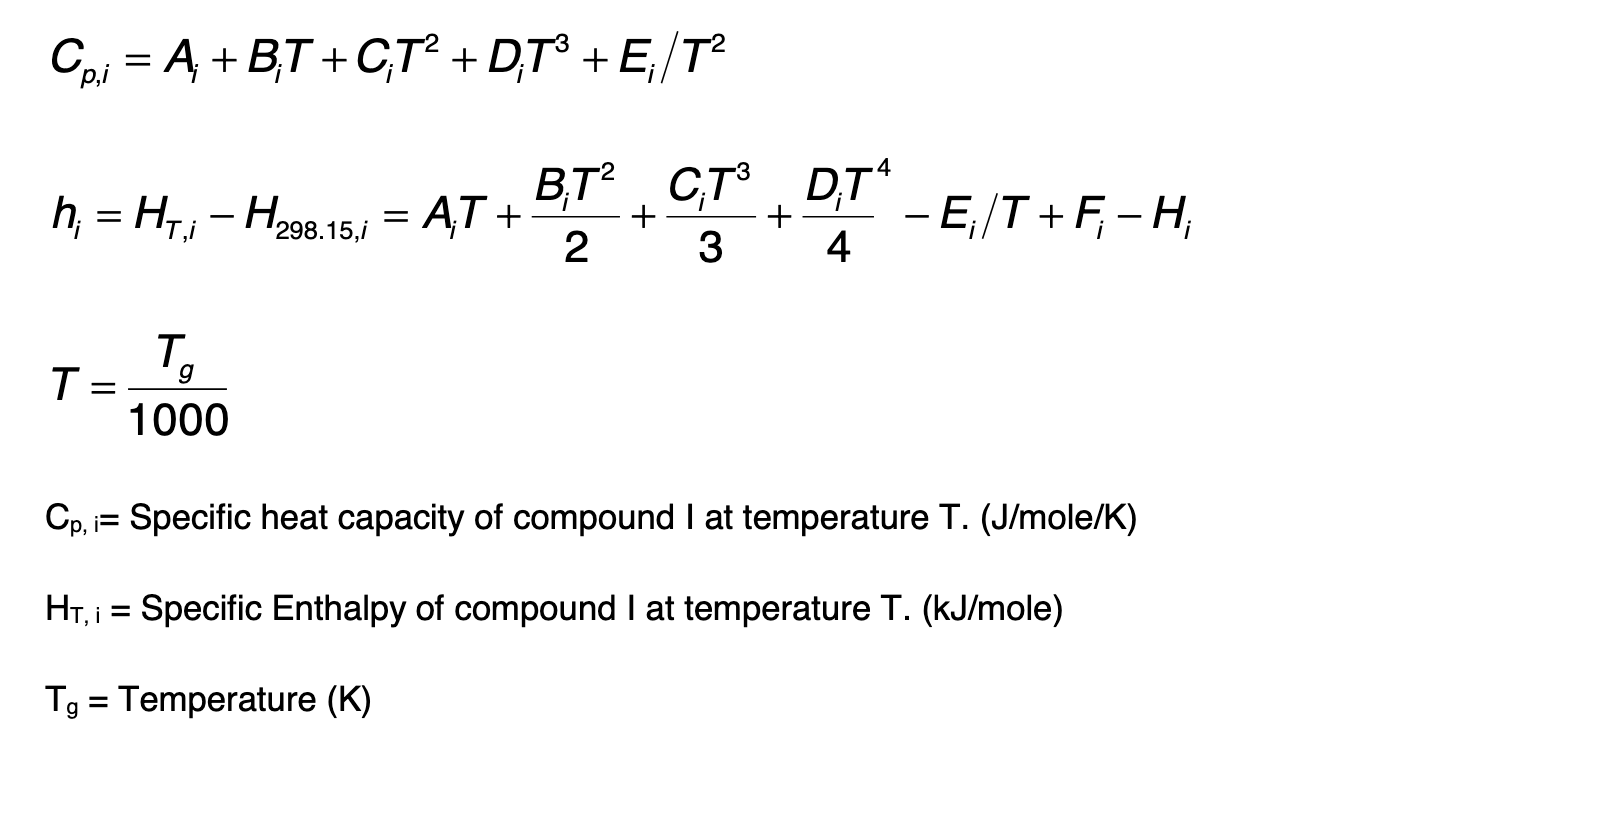

In [82]:
Image(filename='../../External_data/images/Shomate_8.png', width = 700, height = 300)

#### Cantera: Shomate 7
source: cantera documentation https://cantera.org/science/science-species.html

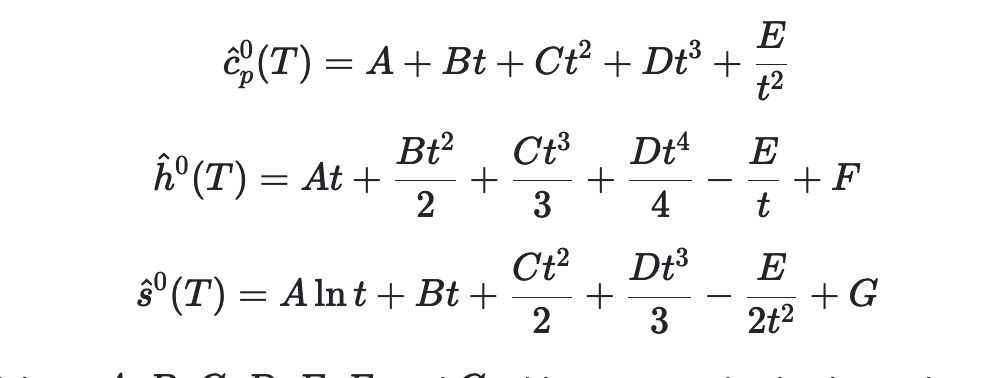

In [83]:
Image(filename='../../External_data/images/Shomate_7.png',width = 700, height = 300) 

### load temp, pressure, and mole fractions from matlab file

In [84]:
if new_run:
    conditions = mat['condition']
    
else: 
    # typo in original grabow data
    conditions = mat['ccondition']

temp = float(conditions['T'])
pres = float(conditions['P'])

print(temp)

# order is COg, CO2g, H2g, CH3OHg, H2Og, HCOOHg, CH2Og
moles = conditions['molfrac'][0][0][0][0][1][0]

feed_moles = {"CO":moles[0], 
              "CO2":moles[1], 
              "H2":moles[2], 
              "CH3OH":moles[3], 
              "H2O":moles[4], 
              "HCOOH":moles[5], 
              "CH2O":moles[6],}

483.5


### load cti file that was imported directly from the supplementary data

In [85]:
# import from supp data
file = "../../External_data/mech_grabow_new.cti"

gas_old = ct.Solution(file, "gas")
surf_old = ct.Interface(file,"surface1", [gas_old])

# initialize T and P
gas_old.TPX = temp, pres, feed_moles
surf_old.TP = temp, pres

### load cti file to a phase that we can modify to look like the matlab file.
this is basically a template that just happens to have all of the species and reactions we want, all the values will be overwritten

In [86]:
file = "../../External_data/mech_grabow_new.cti"

gas = ct.Solution(file, "gas")
surf = ct.Interface(file,"surface1", [gas])

# initialize T and P
gas.TPX = temp, pres, feed_moles
surf.TP = temp, pres

### modify thermo so it matches matlab file

In [87]:
for phase in (gas, surf):
    for S in phase.species():
        index = phase.species_index(S.name)
        print(f"old thermo {S.name} :\n{S.thermo.coeffs}")
        snew = species_dict[S.name].thermo
        S.thermo = snew
        phase.modify_species(index, S)
        print(f"new thermo {S.name} :\n{S.thermo.coeffs}")

old thermo CH2O :
[ 1.0000000e+03  3.0475800e+00  1.0192105e+02 -5.6264150e+01
  1.2545320e+01  6.2240000e-01 -6.0100850e+04  1.9806000e+02
  3.0475800e+00  1.0192105e+02 -5.6264150e+01  1.2545320e+01
  6.2240000e-01 -6.0100850e+04  1.9806000e+02]
new thermo CH2O :
[ 1.00000000e+03  3.04757695e+00  1.01921051e+02 -5.62641543e+01
  1.25453208e+01  6.22400992e-01 -6.01008549e+04  1.98060842e+02
  3.04757695e+00  1.01921051e+02 -5.62641543e+01  1.25453208e+01
  6.22400992e-01 -6.01008549e+04  1.98060842e+02]
old thermo CH3OH :
[ 1.0000000e+03  1.0494520e+01  1.5359317e+02 -9.2857840e+01
  2.4063040e+01  1.9502000e-01 -6.3243140e+04  2.1377000e+02
  1.0494520e+01  1.5359317e+02 -9.2857840e+01  2.4063040e+01
  1.9502000e-01 -6.3243140e+04  2.1377000e+02]
new thermo CH3OH :
[ 1.00000000e+03  1.04945242e+01  1.53593175e+02 -9.28578404e+01
  2.40630373e+01  1.95020308e-01 -6.32431449e+04  2.13767883e+02
  1.04945242e+01  1.53593175e+02 -9.28578404e+01  2.40630373e+01
  1.95020308e-01 -6.324314

### modify reactions so they match matlab file

In [88]:
copy_surf_rxn = surf.reactions()
for irxn, rxn in enumerate(copy_surf_rxn):
    print(f"{rxn.equation} prior : {rxn.rate}")
    
    rxn.rate = rxn_dict[rxn.equation.replace(" ", "")].arrhenius
    surf.modify_reaction(irxn, rxn)
    
    print(f"{rxn.equation} after : {rxn.rate}")    

CO2 + X <=> CO2X prior : Arrhenius(A=1, b=0, E=0)
CO2 + X <=> CO2X after : Arrhenius(A=1, b=0, E=1.0836e+06)
H2 + 2 X <=> 2 HX prior : Arrhenius(A=1, b=0, E=0)
H2 + 2 X <=> 2 HX after : Arrhenius(A=1, b=0, E=4.04419e+07)
CO + X <=> COX prior : Arrhenius(A=1, b=0, E=0)
CO + X <=> COX after : Arrhenius(A=1, b=0, E=0)
H2O + X <=> H2OX prior : Arrhenius(A=1, b=0, E=0)
H2O + X <=> H2OX after : Arrhenius(A=1, b=0, E=0)
HCOOH + X <=> HCOOHX prior : Arrhenius(A=1, b=0, E=0)
HCOOH + X <=> HCOOHX after : Arrhenius(A=1, b=0, E=0)
CH2O + X <=> CH2OX prior : Arrhenius(A=1, b=0, E=0)
CH2O + X <=> CH2OX after : Arrhenius(A=1, b=0, E=327669)
CH3OH + X <=> CH3OHX prior : Arrhenius(A=1, b=0, E=0)
CH3OH + X <=> CH3OHX after : Arrhenius(A=1, b=0, E=0)
HCOOCH3 + X <=> HCOOCH3X prior : Arrhenius(A=1, b=0, E=0)
HCOOCH3 + X <=> HCOOCH3X after : Arrhenius(A=1, b=0, E=4.21761e+06)
COX + OX <=> CO2X + X prior : Arrhenius(A=4.12069e+15, b=0, E=6.27154e+07)
COX + OX <=> CO2X + X after : Arrhenius(A=3.98893e+19, b=

## make yaml files
surf contains thermo and kinetics.

In [146]:
surf.write_yaml('meohsurf.yaml')

### compare enthalpy of reaction for each rxn

In [89]:
print("{:30s}            {:7s}    {:7s}    {:7s} {:7s}  ".format("reaction","cantera","matlab","diff","supp data" ))
for index, rxn in enumerate(surf.reactions()):
    h_cantera = surf.delta_enthalpy[index]/1e6
    h_matlab = rxn_dict[rxn.equation.replace(" ", "")].deltaH
    h_diff = abs(h_cantera - h_matlab)
    
    h_supp_data = surf_old.delta_enthalpy[index]/1e6
    
    
    
    
    print(f"{rxn.equation:35s}:      {h_cantera:6.1f},  {h_matlab:6.1f},  {h_diff:6.1f}  {h_supp_data:6.1f}")
    

reaction                                  cantera    matlab     diff    supp data  
CO2 + X <=> CO2X                   :         0.2,     0.2,     0.0     0.2
H2 + 2 X <=> 2 HX                  :       -45.3,   -45.3,     0.0   -32.2
CO + X <=> COX                     :        -9.8,    -9.8,     0.0   -85.9
H2O + X <=> H2OX                   :       -10.4,   -10.4,     0.0   -10.4
HCOOH + X <=> HCOOHX               :       -77.4,   -77.4,     0.0   -24.2
CH2O + X <=> CH2OX                 :       -39.8,   -39.8,     0.0    -6.4
CH3OH + X <=> CH3OHX               :       -33.8,   -33.8,     0.0   -11.3
HCOOCH3 + X <=> HCOOCH3X           :         4.2,     4.2,     0.0     4.2
COX + OX <=> CO2X + X              :      -109.6,  -109.6,     0.0   -89.3
COX + OHX <=> COOHX + X            :        23.9,    23.9,     0.0    32.7
COOHX + X <=> CO2X + HX            :       -40.0,   -40.0,     0.0   -62.9
COOHX + OHX <=> CO2X + H2OX        :         8.5,     8.5,     0.0   -59.7
COOHX + HX <=> H

### compare species enthalpy

In [90]:
gas.species("CH2O").thermo.coeffs

array([ 1.00000000e+03,  3.04757695e+00,  1.01921051e+02, -5.62641543e+01,
        1.25453208e+01,  6.22400992e-01, -6.01008549e+04,  1.98060842e+02,
        3.04757695e+00,  1.01921051e+02, -5.62641543e+01,  1.25453208e+01,
        6.22400992e-01, -6.01008549e+04,  1.98060842e+02])

In [91]:
gas_old.species("CH2O").thermo.coeffs

array([ 1.0000000e+03,  3.0475800e+00,  1.0192105e+02, -5.6264150e+01,
        1.2545320e+01,  6.2240000e-01, -6.0100850e+04,  1.9806000e+02,
        3.0475800e+00,  1.0192105e+02, -5.6264150e+01,  1.2545320e+01,
        6.2240000e-01, -6.0100850e+04,  1.9806000e+02])

In [92]:
for spec in gas.species():
    
    h_cantera = spec.thermo.h(gas.T)/1e6
    h_matlab = species_dict[spec.name].enthalpy
    
    h_diff = abs(h_cantera - h_matlab)
    h_diff_ev = (h_cantera - h_matlab) / 96 # 96 kJ to Ev 
    
    h_supp = gas_old.species(gas_old.species_index(spec.name)).thermo.h(gas.T)/1e6
    print(f"{spec.name:35s}:      {h_cantera:4.1e},  {h_matlab:4.1e},  {h_diff:4.1e} {h_diff_ev:4.2f} {h_supp:4.1e}")

CH2O                               :      -6.0e+04,  -6.0e+04,  7.3e-12 -0.00 -6.0e+04
CH3OH                              :      -6.3e+04,  -6.3e+04,  1.5e-11 -0.00 -6.3e+04
CO                                 :      -5.7e+04,  -5.7e+04,  0.0e+00 0.00 -5.7e+04
CO2                                :      -9.9e+04,  -9.9e+04,  0.0e+00 0.00 -9.9e+04
H2                                 :      -3.0e+03,  -3.0e+03,  1.4e-12 0.00 -3.0e+03
H2O                                :      -4.5e+04,  -4.5e+04,  1.5e-11 0.00 -4.5e+04
HCOOCH3                            :      -1.2e+05,  -1.2e+05,  4.4e-11 -0.00 -1.2e+05
HCOOH                              :      -1.0e+05,  -1.0e+05,  1.5e-11 -0.00 -1.0e+05


In [93]:
for spec in surf.species():
    
    h_cantera = spec.thermo.h(surf.T)/1e6
    h_matlab = species_dict[spec.name].enthalpy

    h_diff = abs(h_cantera - h_matlab)
    h_diff_ev = (h_cantera - h_matlab) / 96 # 96 kJ to Ev 
    
    h_supp = surf_old.species(surf_old.species_index(spec.name)).thermo.h(gas.T)/1e6
    
    print(f"{spec.name:35s}:      {h_cantera:4.1e},  {h_matlab:4.1e},  {h_diff:4.1e} {h_diff_ev:4.4f} {h_supp:4.1e}")

CH2OHX                             :      -6.2e+04,  -6.2e+04,  1.5e-11 -0.0000 -6.2e+04
CH2OX                              :      -6.0e+04,  -6.0e+04,  7.3e-12 0.0000 -6.0e+04
CH3O2X                             :      -1.0e+05,  -1.0e+05,  2.9e-11 0.0000 -1.0e+05
CH3OHX                             :      -6.3e+04,  -6.3e+04,  7.3e-12 -0.0000 -6.3e+04
CH3OX                              :      -6.2e+04,  -6.2e+04,  1.5e-11 0.0000 -6.2e+04
CO2X                               :      -9.9e+04,  -9.9e+04,  1.5e-11 0.0000 -9.9e+04
CO3X                               :      -1.4e+05,  -1.4e+05,  8.7e-11 -0.0000 -1.4e+05
COHX                               :      -5.8e+04,  -5.8e+04,  0.0e+00 0.0000 -5.8e+04
COOHX                              :      -1.0e+05,  -1.0e+05,  4.4e-11 0.0000 -1.0e+05
COX                                :      -5.7e+04,  -5.7e+04,  1.5e-11 0.0000 -5.7e+04
H2CO2X                             :      -1.0e+05,  -1.0e+05,  2.9e-11 0.0000 -1.0e+05
CH2OOCH3X                    

### compare species entropy

In [94]:
for spec in gas.species():
    
    s_cantera = spec.thermo.s(gas.T)/1e3
    s_matlab = species_dict[spec.name].entropy
    
    s_diff = abs(s_cantera - s_matlab)
    print(f"{spec.name:35s}:      {s_cantera:4.1e},  {s_matlab:4.1e},  {s_diff:4.1e}")

CH2O                               :      2.4e+02,  2.4e+02,  0.0e+00
CH3OH                              :      2.7e+02,  2.7e+02,  0.0e+00
CO                                 :      2.2e+02,  2.2e+02,  2.8e-14
CO2                                :      2.4e+02,  2.4e+02,  0.0e+00
H2                                 :      1.5e+02,  1.5e+02,  5.7e-14
H2O                                :      2.1e+02,  2.1e+02,  2.8e-14
HCOOCH3                            :      3.3e+02,  3.3e+02,  5.7e-14
HCOOH                              :      2.8e+02,  2.8e+02,  0.0e+00


In [95]:
for spec in surf.species():
    s_cantera = spec.thermo.s(surf.T)/1e3
    s_matlab = species_dict[spec.name].entropy
    
    s_diff = abs(s_cantera - s_matlab)
    print(f"{spec.name:35s}:      {s_cantera:4.1e},  {s_matlab:4.1e},  {s_diff:4.1e}")

CH2OHX                             :      1.0e+02,  1.0e+02,  0.0e+00
CH2OX                              :      8.7e+01,  8.7e+01,  0.0e+00
CH3O2X                             :      1.1e+02,  1.1e+02,  1.4e-14
CH3OHX                             :      1.3e+02,  1.3e+02,  1.4e-14
CH3OX                              :      9.7e+01,  9.7e+01,  1.4e-14
CO2X                               :      9.3e+01,  9.3e+01,  2.8e-14
CO3X                               :      1.1e+02,  1.1e+02,  1.4e-14
COHX                               :      8.7e+01,  8.7e+01,  1.4e-14
COOHX                              :      9.5e+01,  9.5e+01,  1.4e-14
COX                                :      7.2e+01,  7.2e+01,  1.4e-14
H2CO2X                             :      1.0e+02,  1.0e+02,  0.0e+00
CH2OOCH3X                          :      1.8e+02,  1.8e+02,  2.8e-14
H2OX                               :      9.6e+01,  9.6e+01,  0.0e+00
HCO3X                              :      1.2e+02,  1.2e+02,  2.8e-14
HCOHX               

### compare rate constants
first, without converting

In [99]:
print("{:30s}            {:7s}    {:7s}    {:7s}   {:7s} ".format("reaction","cantera","matlab","A/B", "supp data"))

for index, rxn in enumerate(surf.reactions()):
    k_cantera = surf.forward_rate_constants[index]
    
    rxn_type = rxn_dict[rxn.equation.replace(" ", "")].rtype 
    
    # sticking coeff rxns
    if rxn_type == 0: 
        if rxn.equation.replace(" ", "") == "H2+2X<=>2HX":
            k_matlab = rxn_dict[rxn.equation.replace(" ", "")].kfwd*((R*temp*1e3)/1.0132e5)/site_density
        else:
            k_matlab = rxn_dict[rxn.equation.replace(" ", "")].kfwd*((R*temp*1e3)/1.0132e5)
    # surface rxns
    else: 
        k_matlab = rxn_dict[rxn.equation.replace(" ", "")].kfwd/site_density
    
    k_diff = (k_cantera/k_matlab)
    k_supp_data = surf_old.forward_rate_constants[index]

    print(f"{rxn.equation:35s}:      {k_cantera:4.2e}  {k_matlab:4.2e}  {k_diff:4.6f}   {k_supp_data :4.2e}")

reaction                                  cantera    matlab     A/B       supp data 
CO2 + X <=> CO2X                   :      3.18e+09  5.54e+09  0.573153   4.16e+09
H2 + 2 X <=> 2 HX                  :      2.86e+13  4.99e+13  0.573445   6.70e+17
CO + X <=> COX                     :      5.21e+09  9.09e+09  0.573142   5.21e+09
H2O + X <=> H2OX                   :      6.50e+09  1.13e+10  0.573145   6.50e+09
HCOOH + X <=> HCOOHX               :      4.07e+09  7.09e+09  0.573143   4.07e+09
CH2O + X <=> CH2OX                 :      4.64e+09  8.09e+09  0.573143   5.03e+09
CH3OH + X <=> CH3OHX               :      4.87e+09  8.50e+09  0.573140   4.87e+09
HCOOCH3 + X <=> HCOOCH3X           :      1.25e+09  2.17e+09  0.573165   3.56e+09
COX + OX <=> CO2X + X              :      2.75e+13  2.74e+13  1.000790   6.91e+08
COX + OHX <=> COOHX + X            :      2.26e+13  2.26e+13  1.000748   2.34e+09
COOHX + X <=> CO2X + HX            :      4.33e+09  4.33e+09  1.001443   1.21e+04
COOHX + OHX <

### reverse rates $k_{rev}$

In [100]:
print("{:30s}            {:7s}    {:7s}    {:7s}   {:7s} ".format("reaction","cantera","matlab","A/B", "supp data"))

for index, rxn in enumerate(surf.reactions()):
    k_cantera = surf.reverse_rate_constants[index]
    
    rxn_type = rxn_dict[rxn.equation.replace(" ", "")].rtype 
    
    # sticking coeff rxns
    if rxn_type == 0: 
        if rxn.equation.replace(" ", "") == "H2+2X<=>2HX":
            k_matlab = rxn_dict[rxn.equation.replace(" ", "")].krev/site_density
        else:
            k_matlab = rxn_dict[rxn.equation.replace(" ", "")].krev
    # surface rxns
    else: 
        k_matlab = rxn_dict[rxn.equation.replace(" ", "")].krev/site_density
    
    k_diff = (k_cantera/k_matlab)
    k_supp_data = surf_old.forward_rate_constants[index]

    print(f"{rxn.equation:35s}:      {k_cantera:4.2e}  {k_matlab:4.2e}  {k_diff:4.6f}   {k_supp_data :4.2e}")

reaction                                  cantera    matlab     A/B       supp data 
CO2 + X <=> CO2X                   :      3.18e+15  5.56e+15  0.572591   4.16e+09
H2 + 2 X <=> 2 HX                  :      1.10e+14  1.92e+14  0.573281   6.70e+17
CO + X <=> COX                     :      3.79e+14  6.61e+14  0.572664   5.21e+09
H2O + X <=> H2OX                   :      6.61e+12  1.15e+13  0.572804   6.50e+09
HCOOH + X <=> HCOOHX               :      1.68e+08  2.94e+08  0.573124   4.07e+09
CH2O + X <=> CH2OX                 :      4.37e+11  7.62e+11  0.572877   5.03e+09
CH3OH + X <=> CH3OHX               :      8.94e+11  1.56e+12  0.572852   4.87e+09
HCOOCH3 + X <=> HCOOCH3X           :      1.12e+16  1.95e+16  0.572534   3.56e+09
COX + OX <=> CO2X + X              :      5.68e+01  5.67e+01  1.002289   6.91e+08
COX + OHX <=> COOHX + X            :      1.88e+17  1.88e+17  1.000246   2.34e+09
COOHX + X <=> CO2X + HX            :      1.16e+05  1.16e+05  1.002030   1.21e+04
COOHX + OHX <

## Equilibrium constant
cantera kinetic eq

In [125]:
kfwd = surf.forward_rate_constants[0]
krev = surf.reverse_rate_constants[0]
keq =kfwd/krev
print(keq, surf.equilibrium_constants[0])

9.9797775173135e-07 9.9797775173135e-07


cantera thermodynamic keq (from van't hoff)

In [139]:
dH = surf.delta_standard_enthalpy[0] * 1e-3 # J/kmol to J/mol
dS = surf.delta_standard_entropy[0] * 1e-3 # J/kmol/K yo J/mol/K

keq = np.exp(-(dH/(R*temp))+(dS/R))
keq

3.74308101376586e-12

In [111]:
kfwd = rxn_dict["CO2+X<=>CO2X"].kfwd
krev = rxn_dict["CO2+X<=>CO2X"].krev
keq = krev/kfwd
print(keq, rxn_dict["CO2+X<=>CO2X"].kfwd,1/keq*rxn_dict["CO2+X<=>CO2X"].kfwd) 

39793858.07037128 139640498.8378423 3.509096770433836


In [102]:
surf.forward_rate_constants[0]
surf.reverse_rate_constants[0]
surf.equilibrium_constants[0]

9.9797775173135e-07

In [142]:
R*temp

4019.819

In [140]:
print("{:30s}            {:7s}    {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff","supp data"))

for index, rxn in enumerate(surf.reactions()):
    K_cantera = surf.equilibrium_constants[index]
    K_matlab = rxn_dict[rxn.equation.replace(" ", "")].Keq
    K_diff = K_cantera/K_matlab
    K_supp_data = surf_old.equilibrium_constants[index]
    
    if K_cantera !=0:
        print(f"{rxn.equation:35s}:      {K_cantera:4.2e},  {K_matlab:4.4e},  {K_diff:4.2f}   {K_supp_data:4.2e}")

reaction                                  cantera    matlab     diff       supp data  
CO2 + X <=> CO2X                   :      9.98e-07,  2.5130e-08,  39.71   9.99e-07
H2 + 2 X <=> 2 HX                  :      2.60e-01,  6.5452e-03,  39.69   1.01e-02
CO + X <=> COX                     :      1.38e-05,  3.4653e-07,  39.71   2.28e+03
H2O + X <=> H2OX                   :      9.83e-04,  2.4772e-05,  39.70   9.83e-04
HCOOH + X <=> HCOOHX               :      2.41e+01,  6.0851e-01,  39.68   4.28e-05
CH2O + X <=> CH2OX                 :      1.06e-02,  2.6773e-04,  39.69   2.61e-06
CH3OH + X <=> CH3OHX               :      5.45e-03,  1.3725e-04,  39.69   2.02e-05
HCOOCH3 + X <=> HCOOCH3X           :      1.12e-07,  2.8120e-09,  39.72   1.12e-07
COX + OX <=> CO2X + X              :      4.83e+11,  4.8392e+11,  1.00   3.11e+09
COX + OHX <=> COOHX + X            :      1.20e-04,  1.1992e-04,  1.00   1.36e-05
COOHX + X <=> CO2X + HX            :      3.74e+04,  3.7382e+04,  1.00   1.09e+07
COO

### forward rate constant A factors $A_{fwd}$

In [32]:
print("{:30s}            {:7s}    {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff","supp data"))

for index, rxn in enumerate(surf.reactions()):
    A_cantera = surf.reactions()[index].rate.pre_exponential_factor
    A_matlab = rxn_dict[rxn.equation.replace(" ", "")].A_orig/(site_density)
    A_diff = A_cantera/A_matlab
    A_supp_data = surf_old.reactions()[index].rate.pre_exponential_factor
    
    if A_cantera !=0:
        print(f"{rxn.equation:35s}:      {A_cantera:4.2e},  {A_matlab:4.4e},  {A_diff:4.2e}   {A_supp_data:4.2e}")

reaction                                  cantera    matlab     diff       supp data  
CO2 + X <=> CO2X                   :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
H2 + 2 X <=> 2 HX                  :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
CO + X <=> COX                     :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
H2O + X <=> H2OX                   :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
HCOOH + X <=> HCOOHX               :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
CH2O + X <=> CH2OX                 :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
CH3OH + X <=> CH3OHX               :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
HCOOCH3 + X <=> HCOOCH3X           :      1.00e+00,  3.4483e+07,  2.90e-08   1.00e+00
COX + OX <=> CO2X + X              :      3.99e+19,  3.9889e+19,  1.00e+00   4.12e+15
COX + OHX <=> COOHX + X            :      1.56e+19,  1.5584e+19,  1.00e+00   1.61e+15
COOHX + X <=> CO2X + HX            :      7.77e+20,  

### forward rate constant activation energy  $E_{a,fwd}$

In [136]:
print("{:30s}            {:7s}    {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff","supp data"))

for index, rxn in enumerate(surf.reactions()):
    Ea_cantera = surf.reactions()[index].rate.activation_energy
    Ea_matlab = rxn_dict[rxn.equation.replace(" ", "")].Ea_corr
    Ea_diff = Ea_cantera-Ea_matlab
    Ea_supp_data = surf_old.reactions()[index].rate.activation_energy
    

    print(f"{rxn.equation:35s}:      {Ea_cantera:4.4e},  {Ea_matlab:4.4e},  {Ea_diff:4.2f}   {Ea_supp_data:4.2e}")

reaction                                  cantera    matlab     diff       supp data  
CO2 + X <=> CO2X                   :      1.0836e+06,  1.0836e+06,  0.00   0.00e+00
H2 + 2 X <=> 2 HX                  :      4.0442e+07,  4.0442e+07,  0.00   0.00e+00
CO + X <=> COX                     :      0.0000e+00,  0.0000e+00,  0.00   0.00e+00
H2O + X <=> H2OX                   :      0.0000e+00,  0.0000e+00,  0.00   0.00e+00
HCOOH + X <=> HCOOHX               :      0.0000e+00,  0.0000e+00,  0.00   0.00e+00
CH2O + X <=> CH2OX                 :      3.2767e+05,  3.2767e+05,  0.00   0.00e+00
CH3OH + X <=> CH3OHX               :      0.0000e+00,  0.0000e+00,  0.00   0.00e+00
HCOOCH3 + X <=> HCOOCH3X           :      4.2176e+06,  4.2176e+06,  0.00   0.00e+00
COX + OX <=> CO2X + X              :      5.7041e+07,  5.7041e+07,  0.00   6.27e+07
COX + OHX <=> COOHX + X            :      5.4045e+07,  5.4045e+07,  0.00   5.40e+07
COOHX + X <=> CO2X + HX            :      1.0417e+08,  1.0417e+08,  0.00 

### create a sbr model and run it 

In [35]:
site_density

2.8999999999999998e-08

In [36]:
# create gas inlet
inlet = ct.Reservoir(gas)

# create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume (divide by 2 per Graaf paper)
rradius = 35e-3
rlength = 70e-3
rvol = (rradius ** 2) * math.pi * rlength/2

# cat area calcs
cat_weight = float(conditions["CatalystWeight"])*1e-3 # [kg]
cat_site_per_wt = 5*61.67*1e-6 # [kmol/kg] 1e-6mol/micromole, 1000g/kg, 1kmol/1000 mol
cat_area = (cat_weight * cat_site_per_wt)/site_density  # [m^3]

# reactor initialization
r = ct.IdealGasReactor(gas, energy="off")

# calculate the available catalyst area in a differential reactor
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol
surf.coverages = "X:1.0"

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
one_atm = ct.one_atm
FC_temp = 293.15
volume_flow = conditions["Flow"] * 60 /(100**3)  #cm^3/min to [m^3/s]
molar_flow = volume_flow * one_atm / (8.3145 * FC_temp)  # [mol/s]
mass_flow = molar_flow * (
    feed_moles["CO"] * mw_co + feed_moles["CO2"] * mw_co2 + feed_moles["H2"] * mw_h2 + feed_moles["H2O"] * mw_h2o
)  # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# A PressureController has a baseline mass flow rate matching the 'master'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(r, exhaust, master=mfc, K=0.01)

# initialize reactor network
sim = ct.ReactorNet([r])

In [37]:
sim.step()

3.4322590648825023e-05

In [38]:
for index, rxn in enumerate(surf.reactions()):
    print(surf.equilibrium_constants[index])

9.9797775173135e-07
0.25975046782687883
1.3760066609580062e-05
0.000983395789910983
24.14313498630099
0.010627048525670183
0.00544791295410084
1.1168594336945026e-07
483196675871.04584
0.00011997721007765995
37360.341856386
29.11634041561075
6339947.355509078
1283.140028008301
9.276532325865087e-12
7.22955571750543e-15
11637438.845445897
1.8163565084156e-17
1.4582010224635443e-05
0.0007490757130565206
601370361.8319033
8.989678554699858e-05
0.016114486843942358
27700968302.79264
0.0005860332678789356
0.0009751328640632994
6.728178968353269e-13
1.7341331630644503e-22
1.3873536876338798e-08
9.415921164075783
1.0629121784424656e-06
721.3947939706264
15272841263032.975
1.2819744890433963e-06
1.6498795444242344e-25
1.5889108314221684e-19
0.04734657640928938
10444182015.483343
110547912053832.55
0.7992122896470697
0.014953870146457875
1.8626759238263097e-14
0.7681781023512864
28407378444115.15
0.6009778661719825
9.382352569689868e-24
5.088057315062785e-05
0.008854937563649459
159170082.67305

## rate calculation scratchpad

In [39]:
# rates are off consistently for the following sticking coefficient reactions:
#                                           cantera   Matlab    Cantera/matlab
# CO + X <=> COX                     :      5.30e+09  2.26e+08  23.4822   
# H2O + X <=> H2OX                   :      6.60e+09  2.81e+08  23.4823   
# HCOOH + X <=> HCOOHX               :      4.13e+09  1.76e+08  23.4822     
# CH3OH + X <=> CH3OHX               :      4.95e+09  2.11e+08  23.4821  

# why? changing the temp caused the value to change slightly, 
# but changing the pressure and number of sites had no effect. 
# plotted below to see if it was linear in T

21.14831946129361 2.7632327150886287


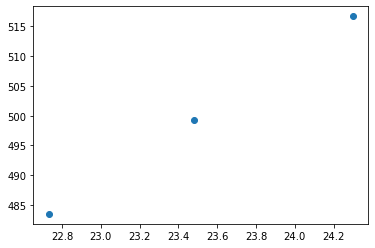

In [40]:
y = [516.7, 483.5, 499.3]
x = [24.3, 22.73, 23.482]

plt.scatter(x, y)

slope, intercept = np.polyfit(x, y, 1)
print(slope, intercept)

Here we calculate the cantera rate constant divided by the matlab one, by dividing thew the equation given in grabow's matlab file and the one given in the cantera documentation. 

## scratchpad
checking calcs above

In [41]:
kb = 1.3806503E-23
Na = 6.0221415E23
mamu = 1.66053886E-27
h = 6.626068E-34
R = 8.314

dS_TS = 36.9904 + (-1)*72.6013

A = (kb * temp / h) * np.exp(dS_TS/R)
print("{:2.10e}".format(A))

A_calc = rxn_dict["H2OX+X<=>HX+OHX"].arrhenius.pre_exponential_factor
print("{:2.4e}".format(A_calc))

old_index = surf_old.reaction_equations().index("H2OX + X <=> HX + OHX")
A_old = surf_old.reactions()[old_index].rate.pre_exponential_factor
print("{:2.4e}".format(A_old))

print(site_density)

1.3900632363e+11
4.7933e+18
4.9517e+14
2.8999999999999998e-08


### activation energy: 

In [42]:
kb = 1.3806503E-23
Na = 6.0221415E23
mamu = 1.66053886E-27
h = 6.626068E-34
R = 8.314

dS_TS = 36.9904 + (-1)*72.6013

Ea  = rxn_dict["H2OX+X<=>HX+OHX"].EaDFT + rxn_dict["H2OX+X<=>HX+OHX"].omega*(rxn_dict["H2OX+X<=>HX+OHX"].deltaH - rxn_dict["H2OX+X<=>HX+OHX"].dHDFT)
print("{:2.10e}".format(Ea))

Ea_calc = rxn_dict["H2OX+X<=>HX+OHX"].arrhenius.activation_energy/1e6
print("{:2.10e}".format(Ea_calc))

old_index = surf_old.reaction_equations().index("H2OX + X <=> HX + OHX")
Ea_old = surf_old.reactions()[old_index].rate.activation_energy/1e6
print("{:2.4e}".format(Ea_old))


6.4864275142e+01
6.4864275142e+01
1.3411e+02


## compare rates
get last row of concentrations to check rates

In [43]:
# load array of partial pressures. load species table to steal header line from that.
partial_press = mat['Y']
time = mat["T"]
pres = float(mat["ccondition"]["P"])*ct.one_atm
temp = float(mat["ccondition"]["T"])

In [44]:
# load reactions to dataframe 
reactions_df = pd.DataFrame(data = reactions[0])

In [45]:
# Extract species names, remove unnecessary characters from column headers
species_names = []
translation = {39: None, 91: None, 93: None} # remove ', [, and ]

for spec in range(len(species[0,:])):
    species_string = str(species[0,spec][0])
    species_string = species_string.translate(translation)
    species_names.append(species_string)
    
# create data frame with species names as column headers
species_df = pd.DataFrame(data=partial_press,columns=species_names)

not ideal, but get second to last row of dataframe with tail and head 

In [46]:
concentration_dict = species_df.tail(1).to_dict(orient='list')
concentration_dict

{'COg': [0.9805628769086625],
 '*': [0.4901985375617578],
 'CO': [1.665691211301099e-07],
 'H2Og': [0.09810682419987207],
 'H2O': [1.1913222067089352e-06],
 'H2g': [10.005282850946571],
 'H': [0.12544318412967226],
 'CO2g': [3.902401456960474],
 'CO2': [4.807152611791522e-08],
 'OH': [0.0068832565444355625],
 'O': [2.4916708446484075e-13],
 'COOH': [2.844427861013008e-13],
 'HCOOH': [5.343392358146183e-07],
 'HCO': [4.153083924984366e-11],
 'HCO2': [0.1432832562915144],
 'H2CO2': [6.64404006099148e-19],
 'CH3O2': [2.8983135606258465e-11],
 'HCOH': [1.4666335303380674e-19],
 'CH2O': [3.296477168401151e-11],
 'CH3O': [0.23374262702649287],
 'CH2OH': [8.913223147424606e-18],
 'CH3OH': [7.64071796128115e-06],
 'CH2Og': [2.5117604199221814e-07],
 'CH3OHg': [0.11356930231018296],
 'HCOOHg': [1.7913376118418204e-06],
 'COH': [2.863451229914745e-20],
 'CO3': [1.156701862233297e-21],
 'HCO3': [3.062685914038287e-16],
 'HCOOCH3g': [1.8390575641841663e-09],
 'HCOOCH3': [2.5349886174369586e-18],
 

In [47]:
sum(list(v[0] for s,v in concentration_dict.items() if 'g' in s))


15.099925355678472

In [48]:
pres/ct.one_atm

15.099925980754998

In [49]:
concentration_dict_gas = {}
concentration_dict_surf = {}

# go through each species and rename. 
# go through each activity for gas species, convert to mole fraction. 

for spec, activ in concentration_dict.items(): 
    
    # rename, remove g, replace "*"" with "X"
    if "g" in spec:
        mole_frac = float(activ[0]) / (pres/ct.one_atm)
        new_spec = spec.replace("g","")
        concentration_dict_gas[new_spec] = mole_frac
        
    elif "*" in spec:
        new_spec = spec.replace("*","X")
        mole_frac = float(activ[0])
        concentration_dict_surf[new_spec] = mole_frac
        
    else:
        new_spec = spec+"X"
        
        # hardcode rename of HCOOX to HCO2X because I am lazy
        if new_spec == "HCO2X":
            new_spec= "HCOOX"
        
        mole_frac = float(activ[0])
        concentration_dict_surf[new_spec] = mole_frac




In [50]:
concentration_dict_gas, "mole fractions"

({'CO': 0.06493825719135309,
  'H2O': 0.006497172524217018,
  'H2': 0.6626047613543538,
  'CO2': 0.25843844942909805,
  'CH2O': 1.6634256506445424e-08,
  'CH3OH': 0.007521182716718488,
  'HCOOH': 1.1863221145089701e-07,
  'HCOOCH3': 1.2179248868690238e-10},
 'mole fractions')

## initialize reactor with second to last row of mole fractions
step forward and get rate constants

### first, do a single calculation from matlab data, and see if this is how the rates were calculated

do it for CO+X<=>COX

turns out they were pretty close. 

In [51]:
k_fwd = rxn_dict['CO+X<=>COX'].kfwd

CO_P = concentration_dict["COg"][0] # CO partial pressure
X_C = concentration_dict["*"][0]  # X surface fraction

rate_rxn1 = k_fwd*CO_P*X_C 
rate_rxn_1_matlab = rxn_dict['CO+X<=>COX'].rfwd
print("our calc: {:1.4e}".format(rate_rxn1))
print("matlab value: {:1.4e}".format(rate_rxn_1_matlab))

our calc: 1.1017e+08
matlab value: 1.1017e+08


In [52]:
# get length of last timestep
delta_T = float(time[-1]) - float(time[-2])

In [53]:
# order is COg, CO2g, H2g, CH3OHg, H2Og, HCOOHg, CH2Og
moles = conditions['molfrac'][0][0][0][0][1][0]

feed_moles = {"CO":moles[0], 
              "CO2":moles[1], 
              "H2":moles[2], 
              "CH3OH":moles[3], 
              "H2O":moles[4], 
              "HCOOH":moles[5], 
              "CH2O":moles[6],}

# initialize T and P
gas.TPX = temp, pres, feed_moles
surf.TP = temp, pres
surf.coverages = {"X":1.0}



# # initialize T and P
# gas.TPX = temp, pres, concentration_dict_gas
# surf.TP = temp, pres
# surf.coverages = concentration_dict_surf

# create gas inlet
inlet = ct.Reservoir(gas)

# create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume (divide by 2 per Graaf paper)
rradius = 35e-3
rlength = 70e-3
rvol = (rradius ** 2) * math.pi * rlength/2

# cat area calcs
cat_weight = float(conditions["CatalystWeight"])*1e-3 # [kg]
cat_site_per_wt = 5*61.67*1e-6 # [kmol/kg] 1e-6mol/micromole, 1000g/kg, 1kmol/1000 mol
cat_area = (cat_weight * cat_site_per_wt)/site_density  # [m^2]


# reactor initialization
r = ct.IdealGasReactor(gas, energy="off")

# calculate the available catalyst area in a differential reactor
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol


# flow controllers (Graaf measured flow at 293.15 and 1 atm)
one_atm = ct.one_atm
FC_temp = 293.15
volume_flow = conditions["Flow"] * 60 /(100**3)  #cm^3/min to [m^3/s]
molar_flow = volume_flow * one_atm / (8.3145 * FC_temp)  # [mol/s]
mass_flow = molar_flow * (
    feed_moles["CO"] * mw_co + feed_moles["CO2"] * mw_co2 + feed_moles["H2"] * mw_h2 + feed_moles["H2O"] * mw_h2o
)  # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# A PressureController has a baseline mass flow rate matching the 'master'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(r, exhaust, master=mfc, K=0.01)


sim.atol = 1e-6
sim.rtol = 1e-3

# initialize reactor network
sim = ct.ReactorNet([r])
sim.initialize()

In [54]:
sim.get_state()

array([7.51830652e-04, 1.34695785e-04, 4.83500000e+02, 0.00000000e+00,
       0.00000000e+00, 1.24142707e-01, 7.83207347e-01, 9.26499458e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00])

## advance sim by $\Delta$T

In [55]:
sim.advance_to_steady_state()

# match rates

matlab rate units: $\frac{mol}{site*s}$  

cantera rate units: $\frac{kmol}{m^{2}*s}$  

multiplication factor: $\frac{kmol}{m^{2}*s}*\frac{10^{3}mol}{kmol}*\frac{m^{2}}{2.9*10^{-5}mol_{site}}*\frac{mole}{6.02*10^{23} sites}$


### unconverted rates

In [56]:
surf()


  surface1:

       temperature   483.5 K
          pressure   1.53e+06 Pa
           density   2.2513e-06 kg/m^3
  mean mol. weight   77.63 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -3.8168e+08        -2.963e+10  J
   internal energy       -3.8168e+08        -2.963e+10  J
           entropy            612.45             47545  J/K
    Gibbs function       -3.8197e+08       -2.9653e+10  J
 heat capacity c_p            351.41             27280  J/K
 heat capacity c_v            351.41             27280  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             CH2OX        4.0144e-11        3.3305e-11            -14992
            CH3O2X        7.4294e-12        5.2157e-12            -25886
            CH3OHX        3.3197e-09         2.696e-09     

In [57]:
print("{:30s}            {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff",))

for index, rxn in enumerate(surf.reactions()):
    r_cantera = surf.forward_rates_of_progress[index]
    r_matlab = rxn_dict[rxn.equation.replace(" ", "")].rfwd
    r_diff = r_cantera/r_matlab
    
    if r_cantera !=0:
        print(f"{rxn.equation:35s}:      {r_cantera:4.4e},  {r_matlab:4.4e},  {r_diff:4.4e}")

reaction                                  cantera    matlab     diff     
CO2 + X <=> CO2X                   :      4.4741e+00,  2.6713e+08,  1.6749e-08
H2 + 2 X <=> 2 HX                  :      1.4781e-03,  8.7766e+04,  1.6842e-08
CO + X <=> COX                     :      1.8288e+00,  1.1017e+08,  1.6600e-08
H2O + X <=> H2OX                   :      8.1203e-05,  1.3744e+07,  5.9084e-12
HCOOH + X <=> HCOOHX               :      2.6773e-06,  1.5700e+02,  1.7053e-08
CH2O + X <=> CH2OX                 :      4.2167e-07,  2.5122e+01,  1.6785e-08
CH3OH + X <=> CH3OHX               :      6.9929e-05,  1.1930e+07,  5.8618e-12
HCOOCH3 + X <=> HCOOCH3X           :      2.2853e-13,  4.9420e-02,  4.6243e-12
COX + OX <=> CO2X + X              :      1.5923e-22,  3.3020e-14,  4.8222e-09
COX + OHX <=> COOHX + X            :      3.6468e-12,  7.5082e-04,  4.8571e-09
COOHX + X <=> CO2X + HX            :      5.5880e-20,  1.7502e-11,  3.1927e-09
COOHX + OHX <=> CO2X + H2OX        :      1.2716e-12,  2.

using units of mol/site/s for rate in matlab

### converted rates

In [58]:
print("{:30s}            {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff",))

for index, rxn in enumerate(surf.reactions()):
    r_cantera = surf.forward_rates_of_progress[index]
    r_matlab = rxn_dict[rxn.equation.replace(" ", "")].rfwd * site_density
    r_diff = r_cantera/r_matlab
    
    if r_cantera !=0:
        print(f"{rxn.equation:35s}:      {r_cantera:4.4e},  {r_matlab:4.4e},  {r_diff:4.8f}")

reaction                                  cantera    matlab     diff     
CO2 + X <=> CO2X                   :      4.4741e+00,  7.7466e+00,  0.57755921
H2 + 2 X <=> 2 HX                  :      1.4781e-03,  2.5452e-03,  0.58074558
CO + X <=> COX                     :      1.8288e+00,  3.1948e+00,  0.57242593
H2O + X <=> H2OX                   :      8.1203e-05,  3.9857e-01,  0.00020374
HCOOH + X <=> HCOOHX               :      2.6773e-06,  4.5531e-06,  0.58801933
CH2O + X <=> CH2OX                 :      4.2167e-07,  7.2854e-07,  0.57878551
CH3OH + X <=> CH3OHX               :      6.9929e-05,  3.4596e-01,  0.00020213
HCOOCH3 + X <=> HCOOCH3X           :      2.2853e-13,  1.4332e-09,  0.00015946
COX + OX <=> CO2X + X              :      1.5923e-22,  9.5757e-22,  0.16628358
COX + OHX <=> COOHX + X            :      3.6468e-12,  2.1774e-11,  0.16748641
COOHX + X <=> CO2X + HX            :      5.5880e-20,  5.0756e-19,  0.11009392
COOHX + OHX <=> CO2X + H2OX        :      1.2716e-12,  6.

### converted reverse rates

In [59]:
print("{:30s}            {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff",))

for index, rxn in enumerate(surf.reactions()):
    r_cantera = surf.reverse_rates_of_progress[index]
    r_matlab = rxn_dict[rxn.equation.replace(" ", "")].rrev * site_density
    r_diff = r_cantera/r_matlab
    
    if r_cantera !=0:
        print(f"{rxn.equation:35s}:      {r_cantera:4.4e},  {r_matlab:4.4e},  {r_diff:4.8f}")

reaction                                  cantera    matlab     diff     
CO2 + X <=> CO2X                   :      4.4741e+00,  7.7466e+00,  0.57755921
H2 + 2 X <=> 2 HX                  :      1.4781e-03,  2.5452e-03,  0.58074554
CO + X <=> COX                     :      1.8288e+00,  3.1948e+00,  0.57242593
H2O + X <=> H2OX                   :      8.1203e-05,  3.9857e-01,  0.00020374
HCOOH + X <=> HCOOHX               :      2.6773e-06,  4.5531e-06,  0.58801986
CH2O + X <=> CH2OX                 :      4.2167e-07,  7.2854e-07,  0.57878597
CH3OH + X <=> CH3OHX               :      6.9929e-05,  3.4596e-01,  0.00020213
HCOOCH3 + X <=> HCOOCH3X           :      2.2853e-13,  1.4332e-09,  0.00015946
COX + OX <=> CO2X + X              :      1.1333e-21,  1.1235e-21,  1.00876952
COX + OHX <=> COOHX + X            :      2.4282e-12,  2.2082e-11,  0.10996231
COOHX + X <=> CO2X + HX            :      5.9736e-19,  5.8721e-19,  1.01728259
COOHX + OHX <=> CO2X + H2OX        :      2.4844e-14,  6.

In [60]:
species_dict[rxn_dict[rxn.equation.replace(" ", "")].species[0]].AtomicMass
m = sum(rxn_dict[rxn.equation.replace(" ", "")].stoichiometry)

In [61]:
print("{:30s}            {:7s}    {:7s}    {:7s}".format("reaction","cantera","cant_obj","A/B"))

for index, rxn in enumerate(surf.reactions()):
    k_cantera = surf.forward_rate_constants[index]
    
    rxn_type = rxn_dict[rxn.equation.replace(" ", "")].rtype 
    
    # sticking coeff rxns
    if rxn_type == 0: 
        
        # get W and m for cantera sticking coeff equation
        # https://cantera.org/science/reactions.html
        W = species_dict[rxn_dict[rxn.equation.replace(" ", "")].species[0]].AtomicMass
        m = rxn_dict[rxn.equation.replace(" ", "")].stoichiometry[1]
#         print("M", m)
        # calculate Kfwd
        A_cantera = surf.reactions()[index].rate.pre_exponential_factor
        Ea_cantera = surf.reactions()[index].rate.activation_energy
        stick = A_cantera*np.exp(-Ea_cantera/(R*1e3*temp))
        k_cantera_calc = (stick/site_density**-m)*np.sqrt(R*1e3*temp/(2*np.pi*W))
        
    # surface rxns
    else: 
        k_cantera_calc = rxn_dict[rxn.equation.replace(" ", "")].kfwd/site_density

    k_diff = abs(k_cantera/k_cantera_calc)
    k_supp_data = surf_old.forward_rate_constants[index]

    print(f"{rxn.equation:35s}:      {k_cantera:4.2e}  {k_cantera_calc:4.2e}  {k_diff:4.4e}")

reaction                                  cantera    cant_obj    A/B    
CO2 + X <=> CO2X                   :      3.18e+09  3.18e+09  1.0000e+00
H2 + 2 X <=> 2 HX                  :      2.86e+13  2.86e+13  1.0006e+00
CO + X <=> COX                     :      5.21e+09  5.21e+09  1.0000e+00
H2O + X <=> H2OX                   :      6.50e+09  6.50e+09  1.0000e+00
HCOOH + X <=> HCOOHX               :      4.07e+09  4.07e+09  1.0000e+00
CH2O + X <=> CH2OX                 :      4.64e+09  4.64e+09  1.0000e+00
CH3OH + X <=> CH3OHX               :      4.87e+09  4.87e+09  1.0000e+00
HCOOCH3 + X <=> HCOOCH3X           :      1.25e+09  1.25e+09  1.0001e+00
COX + OX <=> CO2X + X              :      2.75e+13  2.74e+13  1.0008e+00
COX + OHX <=> COOHX + X            :      2.26e+13  2.26e+13  1.0007e+00
COOHX + X <=> CO2X + HX            :      4.33e+09  4.33e+09  1.0014e+00
COOHX + OHX <=> CO2X + H2OX        :      4.19e+19  4.19e+19  1.0001e+00
COOHX + HX <=> HCOOHX + X          :      8.71e+14 

### calculate matlab rate to confirm we are doing it right

In [62]:
print("{:30s}            {:7s}    {:7s}    {:7s}".format("reaction","matlab","matlab_calc","A/B"))

for index, rxn in enumerate(surf.reactions()):
    k_matlab = rxn_dict[rxn.equation.replace(" ", "")].kfwd
    
    rxn_type = rxn_dict[rxn.equation.replace(" ", "")].rtype 
    
    # sticking coeff rxns
    if rxn_type == 0: 
        
        # get W and m for cantera sticking coeff equation
        # https://cantera.org/science/reactions.html
        W = species_dict[rxn_dict[rxn.equation.replace(" ", "")].species[0]].AtomicMass
        m = sum(rxn_dict[rxn.equation.replace(" ", "")].stoichiometry)
        
        # calculate Kfwd
        stick = rxn_dict[rxn.equation.replace(" ", "")].stickcoeff
        Ea = rxn_dict[rxn.equation.replace(" ", "")].Ea
        k_matlab_calc = rxn_dict[rxn.equation.replace(" ", "")].stickcoeff * 1.0123e6 *((2*np.pi*W*mamu*1e3*kb*10**7*temp)**(-0.5))*1e-15
        k_matlab_calc = k_matlab_calc * np.exp(-Ea/(R*1e-3*temp))
        
    # surface rxns
    else: 
        k_matlab_calc = rxn_dict[rxn.equation.replace(" ", "")].kfwd

    k_diff = abs(k_matlab/k_matlab_calc)
    k_supp_data = surf_old.forward_rate_constants[index]

    print(f"{rxn.equation:35s}:      {k_matlab:4.2e}  {k_matlab_calc:4.2e}  {k_diff:4.4e}")

reaction                                  matlab     matlab_calc    A/B    
CO2 + X <=> CO2X                   :      1.40e+08  1.40e+08  1.0000e+00
H2 + 2 X <=> 2 HX                  :      3.65e+04  3.65e+04  1.0000e+00
CO + X <=> COX                     :      2.29e+08  2.29e+08  1.0000e+00
H2O + X <=> H2OX                   :      2.86e+08  2.86e+08  1.0000e+00
HCOOH + X <=> HCOOHX               :      1.79e+08  1.79e+08  1.0000e+00
CH2O + X <=> CH2OX                 :      2.04e+08  2.04e+08  1.0000e+00
CH3OH + X <=> CH3OHX               :      2.14e+08  2.14e+08  1.0000e+00
HCOOCH3 + X <=> HCOOCH3X           :      5.48e+07  5.48e+07  1.0000e+00
COX + OX <=> CO2X + X              :      7.96e+05  7.96e+05  1.0000e+00
COX + OHX <=> COOHX + X            :      6.55e+05  6.55e+05  1.0000e+00
COOHX + X <=> CO2X + HX            :      1.26e+02  1.26e+02  1.0000e+00
COOHX + OHX <=> CO2X + H2OX        :      1.21e+12  1.21e+12  1.0000e+00
COOHX + HX <=> HCOOHX + X          :      2.52e+

### compare mole fractions and site fractions

In [63]:
print("{:30s}            {:7s}    {:7s}    {:7s}".format("species","cantera","matlab","A/B"))

cant_total = 0 
mat_total = 0 
for spec in gas.species_names:
    
    index = gas.species_index(spec)
    conc_cantera = gas.X[index]
    conc_matlab = concentration_dict_gas[spec]
    conc_diff = abs(conc_cantera/conc_matlab)
    cant_total += conc_cantera
    mat_total += conc_matlab

    print(f"{spec:35s}:      {conc_cantera:4.2e}  {conc_matlab:4.2e}  {conc_diff:4.4f}")

print(cant_total, mat_total)

species                                   cantera    matlab     A/B    
CH2O                               :      1.68e-08  1.66e-08  1.0121
CH3OH                              :      2.66e-06  7.52e-03  0.0004
CO                                 :      6.50e-02  6.49e-02  1.0010
CO2                                :      2.61e-01  2.58e-01  1.0099
H2                                 :      6.74e-01  6.63e-01  1.0172
H2O                                :      2.31e-06  6.50e-03  0.0004
HCOOCH3                            :      3.40e-14  1.22e-10  0.0003
HCOOH                              :      1.22e-07  1.19e-07  1.0282
0.9999999999999999 0.9999999586040008


In [64]:
print("{:30s}            {:7s}    {:7s}    {:7s}".format("species","cantera","matlab","A/B"))

for spec in surf.species_names:
    index = surf.species_index(spec)
    conc_cantera = surf.X[index]
    conc_matlab = concentration_dict_surf[spec]
    conc_diff = abs(conc_cantera/conc_matlab)

    print(f"{spec:35s}:      {conc_cantera:4.2e}  {conc_matlab:4.2e}  {conc_diff:4.4f}")

species                                   cantera    matlab     A/B    
CH2OHX                             :      9.08e-18  8.91e-18  1.0183
CH2OX                              :      3.33e-11  3.30e-11  1.0103
CH3O2X                             :      5.22e-12  2.90e-11  0.1800
CH3OHX                             :      2.70e-09  7.64e-06  0.0004
CH3OX                              :      2.38e-01  2.34e-01  1.0174
CO2X                               :      4.85e-08  4.81e-08  1.0087
CO3X                               :      1.94e-22  1.16e-21  0.1681
COHX                               :      2.89e-20  2.86e-20  1.0099
COOHX                              :      3.13e-14  2.84e-13  0.1102
COX                                :      1.66e-07  1.67e-07  0.9996
H2CO2X                             :      6.83e-19  6.64e-19  1.0275
CH2OOCH3X                          :      8.24e-16  7.99e-16  1.0307
H2OX                               :      4.24e-10  1.19e-06  0.0004
HCO3X                          

In [65]:
site_density

2.8999999999999998e-08

In [66]:
# get meoh rate of production and tof
surf.creation_rates[surf.n_species+gas.species_index("CH3OH")]
# gas.species_names[1]
# gas.species_index("CH3OH")
# len(surf.creation_rates)

1.1542548628832425e-05

In [67]:
gas.species_names

['CH2O', 'CH3OH', 'CO', 'CO2', 'H2', 'H2O', 'HCOOCH3', 'HCOOH']

In [68]:
1/(site_density*Na*10**3)

5.725996079748317e-20

In [69]:
sites_moles = float(conditions["Sites"])
total_sites = sites_moles*Na
total_sites

7.873371885666001e+20

# run supplementary data file 

In [155]:
# order is COg, CO2g, H2g, CH3OHg, H2Og, HCOOHg, CH2Og

# need to load in surface to get site density 
file = "meohsurf.yaml"

gas = ct.Solution(file, "gas")
surf = ct.Interface(file,"surface1", [gas])

feed_moles = {"CO":moles[0], 
              "CO2":moles[1], 
              "H2":moles[2], 
              "CH3OH":moles[3], 
              "H2O":moles[4], 
              "HCOOH":moles[5], 
              "CH2O":moles[6],}

# initialize T and P
gas.TPX = temp, pres, feed_moles
surf.TP = temp, pres
surf.coverages = {"X":1.0}



# # initialize T and P
# gas.TPX = temp, pres, concentration_dict_gas
# surf.TP = temp, pres
# surf.coverages = concentration_dict_surf

# create gas inlet
inlet = ct.Reservoir(gas)

# create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume (divide by 2 per Graaf paper)
rradius = 35e-3
rlength = 70e-3
rvol = (rradius ** 2) * math.pi * rlength/2

# cat area calcs
cat_weight = float(conditions["CatalystWeight"])*1e-3 # [kg]
cat_site_per_wt = 5*61.67*1e-6 # [kmol/kg] 1e-6mol/micromole, 1000g/kg, 1kmol/1000 mol
cat_area = (cat_weight * cat_site_per_wt)/site_density  # [m^2]


# reactor initialization
r = ct.IdealGasReactor(gas, energy="off")

# calculate the available catalyst area in a differential reactor
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol


# flow controllers (Graaf measured flow at 293.15 and 1 atm)
one_atm = ct.one_atm
FC_temp = 293.15
volume_flow = conditions["Flow"] * 60 /(100**3)  #cm^3/min to [m^3/s]
molar_flow = volume_flow * one_atm / (8.3145 * FC_temp)  # [mol/s]
mass_flow = molar_flow * (
    feed_moles["CO"] * mw_co + feed_moles["CO2"] * mw_co2 + feed_moles["H2"] * mw_h2 + feed_moles["H2O"] * mw_h2o
)  # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# A PressureController has a baseline mass flow rate matching the 'master'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(r, exhaust, master=mfc, K=0.01)


sim.atol = 1e-20
sim.rtol = 1e-10

# initialize reactor network
sim = ct.ReactorNet([r])
sim.initialize()

In [156]:
sim.advance_to_steady_state()

In [162]:
gas([])


  gas:

       temperature   483.5 K
          pressure   15.1 Pa
           density   5.5087e-05 kg/m^3
  mean mol. weight   14.666 kg/kmol
   phase of matter   gas

                      mass frac. Y      mole frac. X  
                     ---------------   ---------------
                CO           0.12414             0.065  
               CO2           0.78321             0.261  
                H2           0.09265             0.674  
             HCOOH        3.5919e-12        1.1445e-12  
     [   +4 minor]        3.8323e-16         1.889e-16  



In [160]:
print("{:30s}            {:7s}    {:7s}    {:7s}  ".format("reaction","cantera","matlab","diff",))

for index, rxn in enumerate(surf.reactions()):
    r_cantera = surf.forward_rates_of_progress[index]
    r_matlab = rxn_dict[rxn.equation.replace(" ", "")].rfwd * site_density
    r_diff = r_cantera/r_matlab
    
    if r_cantera !=0:
        print(f"{rxn.equation:35s}:      {r_cantera:4.4e},  {r_matlab:4.4e},  {r_diff:4.8e}")

reaction                                  cantera    matlab     diff     
CO2 + X <=> CO2X                   :      9.0204e-05,  7.7466e+00,  1.16442187e-05
H2 + 2 X <=> 2 HX                  :      6.0877e-08,  2.5452e-03,  2.39182538e-05
CO + X <=> COX                     :      3.6870e-05,  3.1948e+00,  1.15406826e-05
H2O + X <=> H2OX                   :      3.0244e-21,  3.9857e-01,  7.58811914e-21
HCOOH + X <=> HCOOHX               :      5.0647e-16,  4.5531e-06,  1.11237562e-10
CH2O + X <=> CH2OX                 :      9.3228e-20,  7.2854e-07,  1.27965718e-13
CH3OH + X <=> CH3OHX               :      6.5416e-27,  3.4596e-01,  1.89084418e-26
HCOOCH3 + X <=> HCOOCH3X           :      5.1229e-43,  1.4332e-09,  3.57453418e-34
COX + OX <=> CO2X + X              :      3.0178e-34,  9.5757e-22,  3.15149945e-13
COX + OHX <=> COOHX + X            :      2.1713e-26,  2.1774e-11,  9.97218835e-16
COOHX + X <=> CO2X + HX            :      2.9011e-31,  5.0756e-19,  5.71569610e-13
COOHX + OHX <